In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
import numpy as np
import cv2
import utils
import trainer
import evaluator
import data_process
import motion_blur

# Set random seed for reproducibility
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

In [24]:
data_process.download_data()

input_size = 448

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(), # uint8 values in [0, 255] -> float tensor with values [0, 1]
    torchvision.transforms.Normalize(mean=data_process.train_mean.tolist(), std=data_process.train_std.tolist())
])

train_set, val_set, test_set = data_process.load_data(transform=transform, input_size=input_size)

test_set_uni_001 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.01})
test_set_uni_005 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.05})
test_set_uni_01 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'uniform', 'a': 0.1})
test_set_elli_001 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.01})
test_set_elli_005 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.05})
test_set_elli_01 = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'ellipse', 'a': 0.1})
test_set_nat = data_process.NoisySubset(test_set, noise_fn=motion_blur.motion_blur, noise_params={'kernel_type': 'natural'})

Data already exists

Number of valid images: 664
Train set size: 464 - 69.88%
Validation set size: 67 - 10.09%
Test set size: 133 - 20.03%



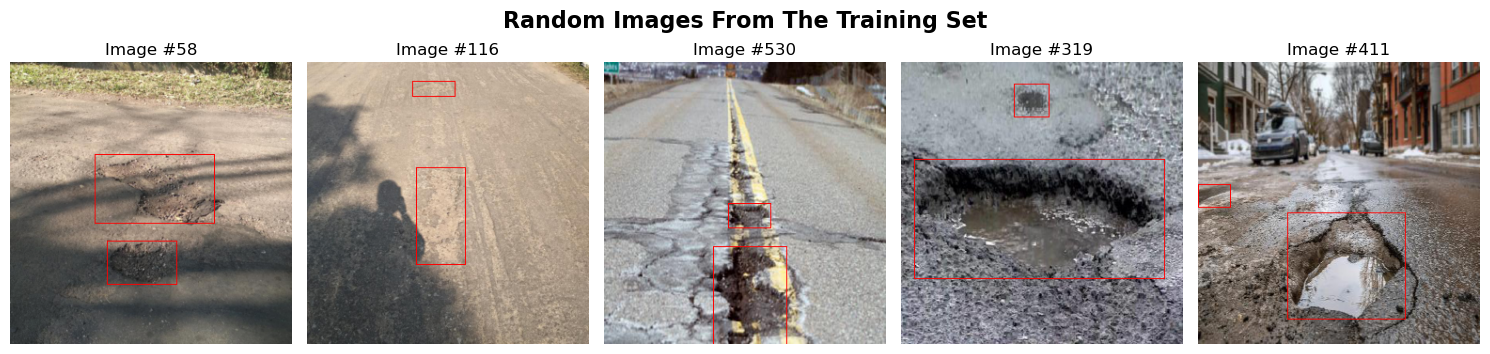

In [16]:
# Display 5 random images from the training set
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, collate_fn=data_process.collate_fn)
images, targets = next(iter(train_loader))
data_process.show_images(images, targets, title="Random Images From The Training Set")

In [26]:
model_name = "fasterrcnn_resnet50_fpn"
model = trainer.get_model(model_name=model_name) 
state_dict = torch.load("data/models/fasterrcnn_resnet50_fpn/fasterrcnn_resnet50_fpn_best.pth", weights_only=True)
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
model.eval()  # Set the model to evaluation mode

# test the model
batch_index = 5
evaluator.test_model(model, test_set, index=batch_index, model_name="fasterrcnn - clean test")
evaluator.test_model(model, test_set_uni_001, index=batch_index, model_name="fasterrcnn - uniform noise - a=0.01")
evaluator.test_model(model, test_set_uni_005, index=batch_index, model_name="fasterrcnn - uniform noise - a=0.05")
evaluator.test_model(model, test_set_uni_01, index=batch_index, model_name="fasterrcnn - uniform noies - a=0.1")
evaluator.test_model(model, test_set_elli_001, index=batch_index, model_name="fasterrcnn - ellipse noise - a=0.01")
evaluator.test_model(model, test_set_elli_005, index=batch_index, model_name="fasterrcnn - ellipse noise - a=0.05")
evaluator.test_model(model, test_set_elli_01, index=batch_index, model_name="fasterrcnn - ellipse noise - a=0.1")
evaluator.test_model(model, test_set_nat, index=batch_index, model_name="fasterrcnn - natural noise")

TypeError: test_model() got an unexpected keyword argument 'device'